### Predicting upvotes for 'AskReddit' subreddit

### prepared by Darwin Lajoie 



## Introduction

The goal in this work is to predict the number of upvotes of reddit comments. We have the dataset 'comments_students.csv' that consist of millions comments from the subreddit "AskReddit". The dataset contains one comment per line and each comment is described with the following 10 attributes:


- created_utc: The time of creation in UTC epoch-second format. Note that neither of these ever have a non-zero fraction.
- ups: The score of the comment. __ It is the attribute to be predicted.__
- subreddit_id: The id of the subreddit in which the thing is located
- link_id: ID of the link this comment is in
- name: Fullname of comment, e.g.\t1_c3v7f8u"
- subreddit: Subreddit of thing excluding the /r/ prex. \pics"
- id: This item's identifier, e.g. \8xwlg"
- author: The account name of the poster
- body: The raw text, this is the unformatted text which includes the raw markup characters such as ** for bold. (<, >, and & are escaped)
- parent_id: ID of the thing this comment is a reply to, either the link or comment in it

The target variable is UPS and I will combine network and text mining techniques to generate features for the regression models.



## Importing libraries and the dataset "comments_students.csv"

In this part we are importing the necessary packages as well as the dataset "comments_students.csv"

In [18]:
%matplotlib inline
# I import pandas and numpy in order to manipulate the data on dataframe format and use severals numerical calculations
import pandas as pd
import numpy as np
# The re library will help in the cleaning process of text data in the column body 
import re
# Matplotlib and seaborn for visualization:
import matplotlib.pyplot as plt
import seaborn as sns

# netowrkx is for the network analysis part
import networkx as nx
from scipy import stats

# Below is a group of librairies and functions for words tokenizations
import nltk
from nltk.tokenize import word_tokenize#RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('punkt')

# below I import a group of libraries and functions regarding feature extractions and modeling
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.pipeline import Pipeline

from sklearn.decomposition import NMF, LatentDirichletAllocation

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
# Here I start by importing the dataset
# The path of comments_students.csv file
filePath = "D:/M2Toulouse/Web mining/Project/data/comments_students.csv"
# Importing the data using read_csv from pandas
df = pd.read_csv(filePath)

In [3]:
# Checking the file size to see how big it is
import os
file_stats = os.stat(filePath)
print(f'File Size in MegaBytes is {file_stats.st_size / (1024 * 1024)}')

File Size in MegaBytes is 993.7862157821655


In [4]:
# A snapshot of the first few lines of the dataframe
df.head()

,created_utc,ups,subreddit_id,link_id,name,subreddit,id,author,body,parent_id
0,1430438400,3.0,t5_2qh1i,t3_34f9rh,t1_cqug90j,AskReddit,cqug90j,jesse9o3,No one has a European accent either because i...,t1_cqug2sr
1,1430438400,3.0,t5_2qh1i,t3_34fvry,t1_cqug90k,AskReddit,cqug90k,beltfedshooter,That the kid ..reminds me of Kevin. so sad :-(,t3_34fvry
2,1430438400,5.0,t5_2qh1i,t3_34ffo5,t1_cqug90z,AskReddit,cqug90z,InterimFatGuy,NSFL,t1_cqu80zb
3,1430438401,1.0,t5_2qh1i,t3_34aqsn,t1_cqug91c,AskReddit,cqug91c,JuanTutrego,I'm a guy and I had no idea this was a thing g...,t1_cqtdj4m
4,1430438401,101.0,t5_2qh1i,t3_34f9rh,t1_cqug91e,AskReddit,cqug91e,dcblackbelt,"Mid twenties male rocking skinny jeans/pants, ...",t1_cquc4rc


In [5]:
# Here we check de dimension of the data
df.shape

(4234970, 10)

## Network Mining


In this part, I created a graph using network mining techniques. My aim is to create a network of comments where the nodes are comments and a node is linked to another one if they have the same parents id. Thus, I use the columns name and parent_id to create my graph. 

After generating the graph, I calculated severals common metrics in network analysis such as degree centrality, closeness centrality... The goal is to see if we can use these metrics as inputs for the modeling part. 

In [6]:
# -----------Network analysis
# I first create an empty network
g= nx.DiGraph()

In [7]:
# Add nodes using the field name from our dataframe df:
g.add_nodes_from(df.name, type="comment")

In [8]:
# Add edges using the field parent_id from the dataframe df
g.add_edges_from(df[["name","parent_id"]].values, link_type="parent")

In [9]:
# First, I want to plot the degree distribution to see if it follows a power-law distribution:
#Calculate and store the degree of each node
deg = nx.degree(g)

In [10]:
# Convert the result (a dict) into a Pandas object, a Series
df_deg = pd.Series([y for (x,y) in deg]) 

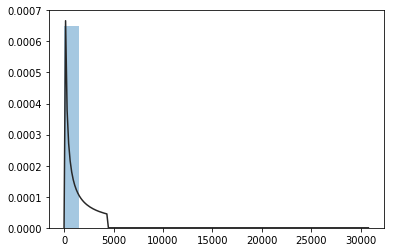

In [11]:
# Now I can use the seaborn distplot function to plot the degree distribution. I am also checking if the graph satifies
# power-law distribution properties
sns.distplot(df_deg,bins=20, kde=False, fit=stats.powerlaw)
plt.show()

In [12]:
# Below I start computing some metrics and add them into the dataframe df so we can use them later on in the modeling part
# Here I calculate de degree centrality of the comments and add the result as column in the dataframe df
degreeCentrality= nx.degree_centrality(g)
df['degreeCentrality'] = df['name'].map(degreeCentrality)

In [13]:
# Here I calculate the closeness centrality of each comments and add the values in the dataframe df
closenessCentrality = nx.closeness_centrality(g)
df['closenessCentrality'] = df['name'].map(closenessCentrality)

In [14]:
# Here we are calculating the eigenvector Centrality of each comments and add the values in our dataframe df
#eigenvectorCentrality = nx.eigenvector_centrality(g)
#df['eigenvectorCentrality'] = df['name'].map(eigenvectorCentrality)

Below I plot the scatterplot of these metrics with the target variable UPS to see the type of relationship. As we can see, though this is not strong, but there is a positive relationship between the closenessCentrality of a comment and 
the number of upvotes it might obtain.

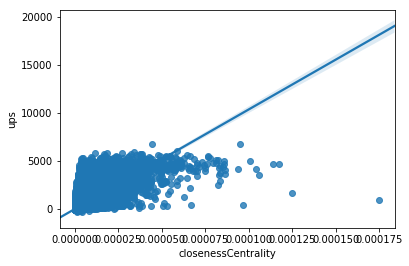

In [19]:
# use the function regplot from seaborn to make a scatterplot between closenessCentrality and the ups variable.  
sns.regplot(x=df["closenessCentrality"], y=df["ups"])
plt.show()

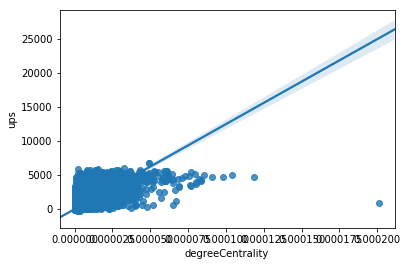

In [20]:
#scatterplot between closenessCentrality and the ups variable
# We can see the same for the scatterplot between degreecentrality and ups, but less stronger than the one before.
sns.regplot(x=df["degreeCentrality"], y=df["ups"])
plt.show()


In [21]:
# Next, I calculate the pagerank and add it into the table df
pagerank = nx.pagerank_scipy(g)
df['pagerank'] = df['name'].map(pagerank)

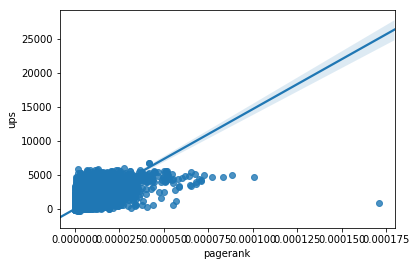

In [22]:
#scatterplot between pagerank variable and the ups variable
sns.regplot(x=df["pagerank"], y=df["ups"])
plt.show()

In [23]:
# I calculate hubs and authorities and also add them in df:
hubs, authorities = nx.hits_scipy(g)
df['hubs'] = df['name'].map(hubs)
df['authorities'] = df['name'].map(authorities)

-------

## Text mining

In this part, I focus on the text analysis part of the project. Precisely, The column of interest is the field "body" that have the contents of the comments. We will start by creating some metrics such as number of words, number of sentences, number of question mark "?". then we will process the column body to create a tf-idf matrix.

In [24]:
# Before dive-in, let's look for columns with NaN values. In fact,some pre-processing technics that I will use below will 
# not workd if the column body contains NaN values
df.isnull().sum()

created_utc                  0
ups                    1016458
subreddit_id                 0
link_id                      0
name                         0
subreddit                    0
id                           0
author                       0
body                        61
parent_id                    0
degreeCentrality             0
closenessCentrality          0
pagerank                     0
hubs                         0
authorities                  0
dtype: int64

In [25]:
# Replace NaN values with "null" strings:
df.body.fillna('null',inplace=True)

### 1- Metrics created from column "body"


Here, we are creating the following metrics and include them in df:

- nb_words : Which is the number of word in each comment. The reason is that I assume that a comment too wordy as well a comment with too few words many push the readers to vote negatively. Though, the number of words might have some influences on ups. 
- nb_exclamation: the number of exclamation points in each comment. The idea is that a comment with exclamations look appealing and can attract upvotes
- nb_Quest: Number of question marks in each comment. Same for the questions. 
- nb_DistinctWords: Number of distinct words in each comment. This metric give an idea of the authors' vocabulary.
- nb_sentences: Number of sentences in each comment. 
- nb_DifficulWords: Number of difficult words in each comment. This metric also give an idea of the authors' vocabulary.

In [26]:
# I have to import the package re and textstat to calculate these metrics. But we already import the re package 
#in the beginning. I also include these metrics as new columns in df:

import textstat

# number of words in each comments:
df['nb_words'] = list(map(lambda x: len(x.split()), df.body))
# Number of exclamation marks in each comments
df['nb_exclamation']= list(map(lambda x: len(re.findall('\!',x)), df.body))
# Number of question marks in each comments
df['nb_Quest']= list(map(lambda x: len(re.findall('\?',x)), df.body))
# Number of different words in each comments
df['nb_DistinctWords'] = list(map(lambda x: len(set((x.split()))), df.body))
# Number of sentences in each comments
df['nb_sentences'] = list(map(lambda x: textstat.sentence_count(x), df.body))
# Number of difficult words in each comments
df['nb_DifficultWords'] = list(map(lambda x: textstat.difficult_words(x), df.body))

### Preprocessing the column "body"

Here, we will process the column body to create a matrix of features with tf-idf technics


In [27]:
# First, let remove the column that we will not need for the modeling
df2 = df.drop(['created_utc','subreddit_id','subreddit','link_id','name','parent_id'],axis=1)

In [28]:
df2.head()

,ups,id,author,body,degreeCentrality,closenessCentrality,pagerank,hubs,authorities,nb_words,nb_exclamation,nb_Quest,nb_DistinctWords,nb_sentences,nb_DifficultWords
0,3.0,cqug90j,jesse9o3,No one has a European accent either because i...,2.275450e-07,0.000000e+00,4.116311e-08,5.030285e-77,0.000000e+00,21,0,0,19,2,5
1,3.0,cqug90k,beltfedshooter,That the kid ..reminds me of Kevin. so sad :-(,2.275450e-07,0.000000e+00,4.116311e-08,1.777681e-26,0.000000e+00,10,0,0,10,1,1
2,5.0,cqug90z,InterimFatGuy,NSFL,2.275450e-07,0.000000e+00,4.116311e-08,7.675606e-66,0.000000e+00,1,0,0,1,1,1
3,1.0,cqug91c,JuanTutrego,I'm a guy and I had no idea this was a thing g...,2.275450e-07,0.000000e+00,4.116311e-08,2.160491e-67,0.000000e+00,14,0,0,13,1,0
4,101.0,cqug91e,dcblackbelt,"Mid twenties male rocking skinny jeans/pants, ...",4.550899e-07,3.033933e-07,2.345763e-07,3.296648e-72,1.547869e-72,43,0,0,39,3,9


Then I create a function to clean the comments. Basically, the function will lowercase all words, removing digits and special characters and then return the clean texts. 

In [29]:
# Stemmer or lemmatizer
#lemmatizer = WordNetLemmatizer()
#stemmer = PorterStemmer() 


def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    cleantext = re.sub('[^A-Za-z\s]+', '', sentence)
    #tokens = word_tokenize(cleantext)  
    #filtered_words = [w for w in tokens  if not w  in stopwords.words('english')]
    #stem_words=[stemmer.stem(w) for w in filtered_words]
    #lemma_words=[lemmatizer.lemmatize(w) for w in filtered_words]
    #return " ".join(cleantext)
    return cleantext

#preprocess(" this is #45467 & \ / . test working broken not working")


In [30]:
# Then I apply the function created on the column 'body'
df2['body']=df2['body'].map(lambda s:preprocess(s)) 



Now, I start the real manipulation of the "body" field. I first create a variable to store the number of features I want to manipulate (i.e., the size of the vocabulary). Then, I build the TF-IDF term-document matrix using the TfidfVectorizer with the following parameter values:

    Filter out words that appear in more than 50% of the documents
    Filter out words that appear in less than 5 documents
    Use the idf
    Filter out english stop words
    Keep only number_of_features words



In [31]:
###---- Vectorizer

n_features = 5000 # vocabulary size
vectorizer = TfidfVectorizer(max_df=0.5, max_features=n_features,min_df=5,
                             stop_words='english',use_idf=True)

In [32]:
# I apply the vectorizer on "body"
X = vectorizer.fit_transform(df2['body'])


In [33]:
print("n_samples: %d, n_features: %d" % X.shape)

n_samples: 4234970, n_features: 5000


In [34]:
# Print the features' names to see:
#vectorizer.get_feature_names()

Now, as I have 5000 words in the vocabulary, many of those words are probably related. One thing we do is to group those related words into the same topics. We have seen in class two possible soft clustering technics that can do exactly that, which are LDA and NMF. Since I use TF-IDF previously, and LDA is only used term frequency, I choose to implement the NMF instead. As a reminder, the LDA and NMF are among algorithms that can be used to group words (dimensionality reduction). 

In [35]:
# Let's  do a topic modeling using nmf. Here, I chose 30 of the mostr representative topic. 
nmf = NMF(n_components=30) # utilisation de la fonction nmf comme paramètre les 25 topics.
nmf.fit(X)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=30, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)

In [36]:
nmf_W = nmf.transform(X)
nmf_H = nmf.components_

In [37]:
# Here I create a function to diplay the topics
def display_topics_full(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(documents[doc_index])
            print("------------------------")

In [38]:
# Here we present the topics kept by the nmf algorithm:
#display_topics_full(nmf_H,nmf_W, vectorizer.get_feature_names(), df2.body, 10, 10)

In [39]:
# Then here, I add these 30 topics as features in my dataset
col_name = ['Topic_'+ str(i) for i in np.arange(0,30)]
df_nmf = pd.DataFrame(nmf_W, columns=col_name)
df3 = pd.concat([df2.reset_index(drop=True), df_nmf.reset_index(drop=True)], axis=1)

-----

## Modeling

Here, we get to the part where we implement several models, and decided which one to submit based on the performances(MAE)

In [40]:
# Because I will remove the column id from the data, let's save the IDs belonging to test part in a variable to use during 
#the submission
test_id = df3.id[df3.ups.isnull()==True]

In [41]:
###--- remove some additional variables we won't need
df3 = df3.drop(['id','author','body'],axis=1)

In [42]:
# Splitting the dataset into training, validation and test set. the set will be where the variable UPS is none.
# 70% of data have values for the target variable ups. so below, I just split this 70% part into training and validation,
# where the validation set will 30% of this part.
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(df3[df3.ups.isnull() == False].drop('ups', axis=1), 
df3.ups[df3.ups.isnull() == False], shuffle=False, test_size = 0.30)
# Then below, I just consider the other part (30%) of the data where ups is none as the test set:
X_test = df3[df3.ups.isnull()== True].drop('ups', axis=1)
y_test = df3.ups[df3.ups.isnull()== True]

In [43]:
# check the training size
X_train.shape

(2252958, 41)

In [44]:
# Check the validation size:
X_valid.shape

(965554, 41)

In [45]:
# And finally check the 
X_test.shape

(1016458, 41)

Below I try a first model, which is LightGBM.LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

    Faster training speed and higher efficiency.
    Lower memory usage.
    Better accuracy.

In [46]:
###-  first model: Light gradient boosting model:
from lightgbm.sklearn import LGBMRegressor
# create regressor object 
lg = LGBMRegressor()
lg.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [47]:
# Prediction performance on the validation set
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_valid, lg.predict(X_valid))

9.823464992291798

My second model is XGboosting model. Another model based on the gradient boosting framework. But, salient features of XGBoost which make it different from other gradient boosting algorithms include:

    Clever penalization of trees
    A proportional shrinking of leaf nodes
    Newton Boosting
    Extra randomization parameter

In [48]:
###-  Second model:  XGboosting model:
import xgboost as xgb
xg = xgb.XGBRegressor()
xg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
       validate_parameters=False, verbosity=None)

In [49]:
# Prediction performance on the validation set
mean_absolute_error(y_valid, xg.predict(X_valid))

9.903711264750095

In [50]:
###-  third model: Light gradient boosting model with 200 trees. the default was 100
from lightgbm.sklearn import LGBMRegressor
# create regressor object 
lg2 = LGBMRegressor(n_estimators=150)
lg2.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=150, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [51]:
# Prediction performance on the validation set
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_valid, lg2.predict(X_valid))

9.823004902785813

We see that, among the models tested, the Light gradient boosting model with default values for the paremeters gives the best performance having the lowest MAE. 

------

### Conclusion

That was an interesting project, where I had the opportunity to apply many technics I learned on network analysis and text mining. One limitation of my work, is that because of limitation of my local computer power, I was not able to implement some algorithms that would have been very insightful. For instance, in the network analysis part, I could not plot the network graph and some of community detections algorithms neither. In the modeling part, I tried to implement some models such as random foret without any success. Furthermore, when trying to implement a grid search to tune the parameters for the Light gradient boosting model, the computer run forever. 

Thus, the results can be improved using other tools such as pyspark that will make use of parallel computing paradigm.
